In [6]:
# using Pkg
# Pkg.add("OrdinaryDiffEq")

In [9]:
using Pkg

# List of required packages
packages = [
    "OrdinaryDiffEq",
    "Flux",
    "Optim",
    "Random",
    "Plots",
    "DiffEqSensitivity",
    "Zygote",
    "ForwardDiff",
    "LinearAlgebra",
    "Statistics",
    "ProgressBars",
    "Printf",
    "Flux.Optimise",
    "Flux.Losses",
    "BSON"
]

# Function to check if a package is installed
function is_installed(pkg)
    try
        eval(Meta.parse("import $pkg"))
        return true
    catch
        return false
    end
end

# Install packages if not already installed
for pkg in packages
    if !is_installed(pkg)
        println("Installing $pkg...")
        Pkg.add(pkg)
    else
        println("$pkg is already installed.")
    end
end


OrdinaryDiffEq is already installed.
Flux is already installed.
Optim is already installed.
Random is already installed.
Plots is already installed.
DiffEqSensitivity is already installed.
Zygote is already installed.
ForwardDiff is already installed.
LinearAlgebra is already installed.
Statistics is already installed.
ProgressBars is already installed.
Printf is already installed.
Flux.Optimise is already installed.
Flux.Losses is already installed.
BSON is already installed.


In [10]:
using OrdinaryDiffEq, Flux, Optim, Random, Plots
using DiffEqSensitivity
using Zygote
using ForwardDiff
using LinearAlgebra, Statistics
using ProgressBars, Printf
using Flux.Optimise: update!, ExpDecay
using Flux.Losses: mae, mse
using BSON: @save, @load

Random.seed!(1234);

###################################
# Arguments
is_restart = true;
n_epoch = 10000;
n_plot = 50;
datasize = 50;
tstep = 1;
n_exp_train = 20;
n_exp_test = 10;
n_exp = n_exp_train + n_exp_test;
noise = 0.05;
ns = 6;
nr = 3;
alg = AutoTsit5(Rosenbrock23(autodiff=false));
atol = 1e-6;
rtol = 1e-3;

# opt = ADAMW(5.f-3, (0.9, 0.999), 1.f-6);
opt = Flux.Optimiser(ExpDecay(5e-3, 0.5, 500 * n_exp_train, 1e-4),
                     ADAMW(0.005, (0.9, 0.999), 1.f-6));

lb = 1.f-6;
ub = 1.f1;
####################################

function trueODEfunc(dydt, y, k, t)
    # TG(1),ROH(2),DG(3),MG(4),GL(5),R'CO2R(6)
    r1 = k[1] * y[1] * y[2];
    r2 = k[2] * y[3] * y[2];
    r3 = k[3] * y[4] * y[2];
    dydt[1] = - r1;  # TG
    dydt[2] = - r1 - r2 - r3;  # TG
    dydt[3] = r1 - r2;  # DG
    dydt[4] = r2 - r3;  # MG
    dydt[5] = r3;  # GL
    dydt[6] = r1 + r2 + r3;  # R'CO2R
    dydt[7] = 0.f0;
end

logA = Float32[18.60f0, 19.13f0, 7.93f0];
Ea = Float32[14.54f0, 14.42f0, 6.47f0];  # kcal/mol

function Arrhenius(logA, Ea, T)
    R = 1.98720425864083f-3
    k = exp.(logA) .* exp.(-Ea ./ R ./ T)
    return k
end

# Generate datasets
u0_list = rand(Float32, (n_exp, ns + 1));
u0_list[:, 1:2] = u0_list[:, 1:2] .* 2.0 .+ 0.2;
u0_list[:, 3:ns] .= 0.0;
u0_list[:, ns + 1] = u0_list[:, ns + 1] .* 20.0 .+ 323.0;  # T[K]
tspan = Float32[0.0, datasize * tstep];
tsteps = range(tspan[1], tspan[2], length=datasize);

ode_data_list = zeros(Float32, (n_exp, ns, datasize));
yscale_list = [];
function max_min(ode_data)
    return maximum(ode_data, dims=2) .- minimum(ode_data, dims=2) .+ lb
end
for i in 1:n_exp
    u0 = u0_list[i, :]
    k = Arrhenius(logA, Ea, u0[end])
    prob_trueode = ODEProblem(trueODEfunc, u0, tspan, k)
    ode_data = Array(solve(prob_trueode, alg, saveat=tsteps))[1:end - 1, :]
    ode_data += randn(size(ode_data)) .* ode_data .* noise
    ode_data_list[i, :, :] = ode_data
    push!(yscale_list, max_min(ode_data))
end
yscale = maximum(hcat(yscale_list...), dims=2);

np = nr * (ns + 2) + 1;
p = randn(Float32, np) .* 0.1;
p[1:nr] .+= 0.8;
p[nr * (ns + 1) + 1:nr * (ns + 2)] .+= 0.8;
p[end] = 0.1;

function p2vec(p)
    slope = p[nr * (ns + 2) + 1] .* 100
    w_b = p[1:nr] .* slope
    w_out = reshape(p[nr + 1:nr * (ns + 1)], ns, nr)
    w_in_Ea = abs.(p[nr * (ns + 1) + 1:nr * (ns + 2)] .* slope)
    w_in = clamp.(-w_out, 0, 4)
    w_in = vcat(w_in, w_in_Ea')
    return w_in, w_b, w_out
end

inv_R = - 1 / 1.98720425864083f-3;
function crnn(du, u, p, t)
    logX = @. log(clamp(u[1:end - 1], lb, ub))
    w_in_x = w_in' * vcat(logX, inv_R / u[end])
    du .= vcat(w_out * (@. exp(w_in_x + w_b)), 0.f0)
end

u0 = u0_list[1, :];
prob = ODEProblem(crnn, u0, tspan, saveat=tsteps, atol=atol, rtol=rtol)


sense = BacksolveAdjoint(checkpointing=true; autojacvec=ZygoteVJP());
function predict_neuralode(u0, p)
    global w_in, w_b, w_out = p2vec(p)
    pred = clamp.(Array(solve(prob, alg, u0=u0, p=p, sensalg=sense)), -ub, ub)
    return pred
end
predict_neuralode(u0, p)


LoadError: UndefVarError: `BacksolveAdjoint` not defined

In [12]:
using OrdinaryDiffEq, Flux, Optim, Random, Plots
using DiffEqSensitivity
using Zygote
using ForwardDiff
using LinearAlgebra, Statistics
using ProgressBars, Printf
using Flux.Optimise: update!, ExpDecay
using Flux.Losses: mae, mse
using BSON: @save, @load

Random.seed!(1234);

###################################
# Arguments
is_restart = true;
n_epoch = 10000;
n_plot = 50;
datasize = 50;
tstep = 1;
n_exp_train = 20;
n_exp_test = 10;
n_exp = n_exp_train + n_exp_test;
noise = 0.05;
ns = 6;
nr = 3;
alg = AutoTsit5(Rosenbrock23(autodiff=false));
atol = 1e-6;
rtol = 1e-3;

opt = Flux.Optimiser(ExpDecay(5e-3, 0.5, 500 * n_exp_train, 1e-4), ADAMW(0.005, (0.9, 0.999), 1.f-6));

lb = 1.f-6;
ub = 1.f1;
####################################

function trueODEfunc(dydt, y, k, t)
    # TG(1),ROH(2),DG(3),MG(4),GL(5),R'CO2R(6)
    r1 = k[1] * y[1] * y[2];
    r2 = k[2] * y[3] * y[2];
    r3 = k[3] * y[4] * y[2];
    dydt[1] = - r1;  # TG
    dydt[2] = - r1 - r2 - r3;  # TG
    dydt[3] = r1 - r2;  # DG
    dydt[4] = r2 - r3;  # MG
    dydt[5] = r3;  # GL
    dydt[6] = r1 + r2 + r3;  # R'CO2R
    dydt[7] = 0.f0;
end

logA = Float32[18.60f0, 19.13f0, 7.93f0];
Ea = Float32[14.54f0, 14.42f0, 6.47f0];  # kcal/mol

function Arrhenius(logA, Ea, T)
    R = 1.98720425864083f-3
    k = exp.(logA) .* exp.(-Ea ./ R ./ T)
    return k
end

# Generate datasets
u0_list = rand(Float32, (n_exp, ns + 1));
u0_list[:, 1:2] = u0_list[:, 1:2] .* 2.0 .+ 0.2;
u0_list[:, 3:ns] .= 0.0;
u0_list[:, ns + 1] = u0_list[:, ns + 1] .* 20.0 .+ 323.0;  # T[K]
tspan = Float32[0.0, datasize * tstep];
tsteps = range(tspan[1], tspan[2], length=datasize);

ode_data_list = zeros(Float32, (n_exp, ns, datasize));
yscale_list = [];
function max_min(ode_data)
    return maximum(ode_data, dims=2) .- minimum(ode_data, dims=2) .+ lb
end
for i in 1:n_exp
    u0 = u0_list[i, :]
    k = Arrhenius(logA, Ea, u0[end])
    prob_trueode = ODEProblem(trueODEfunc, u0, tspan, k)
    ode_data = Array(solve(prob_trueode, alg, saveat=tsteps))[1:end - 1, :]
    ode_data += randn(size(ode_data)) .* ode_data .* noise
    ode_data_list[i, :, :] = ode_data
    push!(yscale_list, max_min(ode_data))
end
yscale = maximum(hcat(yscale_list...), dims=2);

np = nr * (ns + 2) + 1;
p = randn(Float32, np) .* 0.1;
p[1:nr] .+= 0.8;
p[nr * (ns + 1) + 1:nr * (ns + 2)] .+= 0.8;
p[end] = 0.1;

function p2vec(p)
    slope = p[nr * (ns + 2) + 1] .* 100
    w_b = p[1:nr] .* slope
    w_out = reshape(p[nr + 1:nr * (ns + 1)], ns, nr)
    w_in_Ea = abs.(p[nr * (ns + 1) + 1:nr * (ns + 2)] .* slope)
    w_in = clamp.(-w_out, 0, 4)
    w_in = vcat(w_in, w_in_Ea')
    return w_in, w_b, w_out
end

inv_R = - 1 / 1.98720425864083f-3;
function crnn(du, u, p, t)
    logX = @. log(clamp(u[1:end - 1], lb, ub))
    w_in_x = w_in' * vcat(logX, inv_R / u[end])
    du .= vcat(w_out * (@. exp(w_in_x + w_b)), 0.f0)
end

u0 = u0_list[1, :];
prob = ODEProblem(crnn, u0, tspan, saveat=tsteps, atol=atol, rtol=rtol)

sense = BacksolveAdjoint(checkpointing=true; autojacvec=Zygote)
function predict_neuralode(u0, p)
    global w_in, w_b, w_out = p2vec(p)
    pred = clamp.(Array(solve(prob, alg, u0=u0, p=p, sensalg=sense)), -ub, ub)
    return pred
end

# Example of calling the predict_neuralode function
predict_neuralode(u0, p)


LoadError: UndefVarError: `BacksolveAdjoint` not defined

In [14]:
using OrdinaryDiffEq, Flux, Optim, Random, Plots
using DiffEqSensitivity
using Zygote
using ForwardDiff
using LinearAlgebra, Statistics
using ProgressBars, Printf
using Flux.Optimise: update!, ExpDecay
using Flux.Losses: mae, mse
using BSON: @save, @load

Random.seed!(1234);

###################################
# Arguments
is_restart = true;
n_epoch = 10000;
n_plot = 50;
datasize = 50;
tstep = 1;
n_exp_train = 20;
n_exp_test = 10;
n_exp = n_exp_train + n_exp_test;
noise = 0.05;
ns = 6;
nr = 3;
alg = AutoTsit5(Rosenbrock23(autodiff=false));
atol = 1e-6;
rtol = 1e-3;

# opt = ADAMW(5.f-3, (0.9, 0.999), 1.f-6);
opt = Flux.Optimiser(ExpDecay(5e-3, 0.5, 500 * n_exp_train, 1e-4),
                     ADAMW(0.005, (0.9, 0.999), 1.f-6));

lb = 1.f-6;
ub = 1.f1;
####################################

function trueODEfunc(dydt, y, k, t)
    # TG(1),ROH(2),DG(3),MG(4),GL(5),R'CO2R(6)
    r1 = k[1] * y[1] * y[2];
    r2 = k[2] * y[3] * y[2];
    r3 = k[3] * y[4] * y[2];
    dydt[1] = - r1;  # TG
    dydt[2] = - r1 - r2 - r3;  # TG
    dydt[3] = r1 - r2;  # DG
    dydt[4] = r2 - r3;  # MG
    dydt[5] = r3;  # GL
    dydt[6] = r1 + r2 + r3;  # R'CO2R
    dydt[7] = 0.f0;
end

logA = Float32[18.60f0, 19.13f0, 7.93f0];
Ea = Float32[14.54f0, 14.42f0, 6.47f0];  # kcal/mol

function Arrhenius(logA, Ea, T)
    R = 1.98720425864083f-3
    k = exp.(logA) .* exp.(-Ea ./ R ./ T)
    return k
end

# Generate datasets
u0_list = rand(Float32, (n_exp, ns + 1));
u0_list[:, 1:2] = u0_list[:, 1:2] .* 2.0 .+ 0.2;
u0_list[:, 3:ns] .= 0.0;
u0_list[:, ns + 1] = u0_list[:, ns + 1] .* 20.0 .+ 323.0;  # T[K]
tspan = Float32[0.0, datasize * tstep];
tsteps = range(tspan[1], tspan[2], length=datasize);

ode_data_list = zeros(Float32, (n_exp, ns, datasize));
yscale_list = [];
function max_min(ode_data)
    return maximum(ode_data, dims=2) .- minimum(ode_data, dims=2) .+ lb
end
for i in 1:n_exp
    u0 = u0_list[i, :]
    k = Arrhenius(logA, Ea, u0[end])
    prob_trueode = ODEProblem(trueODEfunc, u0, tspan, k)
    ode_data = Array(solve(prob_trueode, alg, saveat=tsteps))[1:end - 1, :]
    ode_data += randn(size(ode_data)) .* ode_data .* noise
    ode_data_list[i, :, :] = ode_data
    push!(yscale_list, max_min(ode_data))
end
yscale = maximum(hcat(yscale_list...), dims=2);

np = nr * (ns + 2) + 1;
p = randn(Float32, np) .* 0.1;
p[1:nr] .+= 0.8;
p[nr * (ns + 1) + 1:nr * (ns + 2)] .+= 0.8;
p[end] = 0.1;

function p2vec(p)
    slope = p[nr * (ns + 2) + 1] .* 100
    w_b = p[1:nr] .* slope
    w_out = reshape(p[nr + 1:nr * (ns + 1)], ns, nr)
    w_in_Ea = abs.(p[nr * (ns + 1) + 1:nr * (ns + 2)] .* slope)
    w_in = clamp.(-w_out, 0, 4)
    w_in = vcat(w_in, w_in_Ea')
    return w_in, w_b, w_out
end

function display_p(p)
    w_in, w_b, w_out = p2vec(p);
    println("species (column) reaction (row)")
    println("w_in | w_b")
    w_in_ = vcat(w_in, w_b')'
    show(stdout, "text/plain", round.(w_in_, digits=3))
    println("\nw_out")
    show(stdout, "text/plain", round.(w_out', digits=3))
    println("\n")
end
display_p(p)

inv_R = - 1 / 1.98720425864083f-3;
function crnn(du, u, p, t)
    logX = @. log(clamp(u[1:end - 1], lb, ub))
    w_in_x = w_in' * vcat(logX, inv_R / u[end])
    du .= vcat(w_out * (@. exp(w_in_x + w_b)), 0.f0)
end

u0 = u0_list[1, :];
prob = ODEProblem(crnn, u0, tspan, saveat=tsteps, atol=atol, rtol=rtol)

sense = BacksolveAdjoint(checkpointing=true; autojacvec=ZygoteVJP());
function predict_neuralode(u0, p)
    global w_in, w_b, w_out = p2vec(p)
    pred = clamp.(Array(solve(prob, alg, u0=u0, p=p, sensalg=sense)), -ub, ub)
    return pred
end
predict_neuralode(u0, p)

i_obs = [1, 2, 3, 4, 5, 6];
function loss_neuralode(p, i_exp)
    ode_data = @view ode_data_list[i_exp, i_obs, :]
    pred = predict_neuralode(u0_list[i_exp, :], p)[i_obs, :]
    loss = mae(ode_data ./ yscale[i_obs], pred ./ yscale[i_obs])
    return loss
end

cbi = function (p, i_exp)
    ode_data = ode_data_list[i_exp, :, :]
    pred = predict_neuralode(u0_list[i_exp, :], p)
    l_plt = []
    for i in 1:ns
        plt = scatter(tsteps, ode_data[i,:], markercolor=:transparent,
                      title=string(i), label=string("data_", i))
        plot!(plt, tsteps, pred[i,:], label=string("pred_", i))
        push!(l_plt, plt)
    end
    plt_all = plot(l_plt..., legend=false)
    png(plt_all, string("figs/i_exp_", i_exp))
    return false
end

l_loss_train = []
l_loss_val = []
iter = 1
cb = function (p, loss_train, loss_val)
    global l_loss_train, l_loss_val, iter
    push!(l_loss_train, loss_train)
    push!(l_loss_val, loss_val)

    if iter % n_plot == 0
        display_p(p)
        @printf("min loss train %.4e val %.4e\n", minimum(l_loss_train), minimum(l_loss_val))

        l_exp = randperm(n_exp)[1:1];
        println("update plot for ", l_exp)
        for i_exp in l_exp
            cbi(p, i_exp)
        end

        plt_loss = plot(l_loss_train, xscale=:log10, yscale=:log10, 
                        framestyle=:box, label="Training")
        plot!(plt_loss, l_loss_val, label="Validation")
        plot!(xlabel="Epoch", ylabel="Loss")
        png(plt_loss, "figs/loss")

        @save "./checkpoint/mymodel.bson" p opt l_loss_train l_loss_val iter;
    end
    iter += 1;
end

if is_restart
    @load "./checkpoint/mymodel.bson" p opt l_loss_train l_loss_val iter;
    iter += 1;
end

i_exp = 1
epochs = ProgressBar(iter:n_epoch);
loss_epoch = zeros(Float32, n_exp);
grad_norm = zeros(Float32, n_exp_train);
for epoch in epochs
    global p
    for i_exp in randperm(n_exp_train)
        grad = ForwardDiff.gradient(x -> loss_neuralode(x, i_exp), p)
        grad_norm[i_exp] = norm(grad, 2)
        update!(opt, p, grad)
    end
    for i_exp in 1:n_exp
        loss_epoch[i_exp] = loss_neuralode(p, i_exp)
    end
    loss_train = mean(loss_epoch[1:n_exp_train]);
    loss_val = mean(loss_epoch[n_exp_train + 1:end]);
    set_description(epochs, string(@sprintf("Loss train %.2e val %.2e gnorm %.1e lr %.1e", 
                                             loss_train, loss_val, mean(grad_norm), opt[1].eta)))
    cb(p, loss_train, loss_val);
end

for i_exp in 1:n_exp
    cbi(p, i_exp)
end


species (column) reaction (row)
w_in | w_b
3×8 Matrix{Float64}:
 0.008  0.0    0.071  0.0    0.026  0.053  5.571  6.743
 0.097  0.031  0.0    0.162  0.0    0.0    7.731  6.617
 0.0    0.0    0.0    0.0    0.091  0.091  5.891  8.017
w_out
3×6 Matrix{Float64}:
 -0.008   0.053  -0.071   0.095  -0.026  -0.053
 -0.097  -0.031   0.006  -0.162   0.158   0.251
  0.022   0.051   0.126   0.103  -0.091  -0.091



LoadError: UndefVarError: `ZygoteVJP` not defined

In [15]:
using OrdinaryDiffEq, Flux, Optim, Random, Plots
using DiffEqSensitivity
using Zygote
using ForwardDiff
using LinearAlgebra, Statistics
using ProgressBars, Printf
using Flux.Optimise: update!, ExpDecay
using Flux.Losses: mae, mse
using BSON: @save, @load

Random.seed!(1234);

###################################
# Arguments
is_restart = true;
n_epoch = 10000;
n_plot = 50;
datasize = 50;
tstep = 1;
n_exp_train = 20;
n_exp_test = 10;
n_exp = n_exp_train + n_exp_test;
noise = 0.05;
ns = 6;
nr = 3;
alg = AutoTsit5(Rosenbrock23(autodiff=false));
atol = 1e-6;
rtol = 1e-3;

# opt = ADAMW(5.f-3, (0.9, 0.999), 1.f-6);
opt = Flux.Optimiser(ExpDecay(5e-3, 0.5, 500 * n_exp_train, 1e-4),
                     ADAMW(0.005, (0.9, 0.999), 1.f-6));

lb = 1.f-6;
ub = 1.f1;
####################################

function trueODEfunc(dydt, y, k, t)
    # TG(1),ROH(2),DG(3),MG(4),GL(5),R'CO2R(6)
    r1 = k[1] * y[1] * y[2];
    r2 = k[2] * y[3] * y[2];
    r3 = k[3] * y[4] * y[2];
    dydt[1] = - r1;  # TG
    dydt[2] = - r1 - r2 - r3;  # TG
    dydt[3] = r1 - r2;  # DG
    dydt[4] = r2 - r3;  # MG
    dydt[5] = r3;  # GL
    dydt[6] = r1 + r2 + r3;  # R'CO2R
    dydt[7] = 0.f0;
end

logA = Float32[18.60f0, 19.13f0, 7.93f0];
Ea = Float32[14.54f0, 14.42f0, 6.47f0];  # kcal/mol

function Arrhenius(logA, Ea, T)
    R = 1.98720425864083f-3
    k = exp.(logA) .* exp.(-Ea ./ R ./ T)
    return k
end

# Generate datasets
u0_list = rand(Float32, (n_exp, ns + 1));
u0_list[:, 1:2] = u0_list[:, 1:2] .* 2.0 .+ 0.2;
u0_list[:, 3:ns] .= 0.0;
u0_list[:, ns + 1] = u0_list[:, ns + 1] .* 20.0 .+ 323.0;  # T[K]
tspan = Float32[0.0, datasize * tstep];
tsteps = range(tspan[1], tspan[2], length=datasize);

ode_data_list = zeros(Float32, (n_exp, ns, datasize));
yscale_list = [];
function max_min(ode_data)
    return maximum(ode_data, dims=2) .- minimum(ode_data, dims=2) .+ lb
end
for i in 1:n_exp
    u0 = u0_list[i, :]
    k = Arrhenius(logA, Ea, u0[end])
    prob_trueode = ODEProblem(trueODEfunc, u0, tspan, k)
    ode_data = Array(solve(prob_trueode, alg, saveat=tsteps))[1:end - 1, :]
    ode_data += randn(size(ode_data)) .* ode_data .* noise
    ode_data_list[i, :, :] = ode_data
    push!(yscale_list, max_min(ode_data))
end
yscale = maximum(hcat(yscale_list...), dims=2);

np = nr * (ns + 2) + 1;
p = randn(Float32, np) .* 0.1;
p[1:nr] .+= 0.8;
p[nr * (ns + 1) + 1:nr * (ns + 2)] .+= 0.8;
p[end] = 0.1;

function p2vec(p)
    slope = p[nr * (ns + 2) + 1] .* 100
    w_b = p[1:nr] .* slope
    w_out = reshape(p[nr + 1:nr * (ns + 1)], ns, nr)
    w_in_Ea = abs.(p[nr * (ns + 1) + 1:nr * (ns + 2)] .* slope)
    w_in = clamp.(-w_out, 0, 4)
    w_in = vcat(w_in, w_in_Ea')
    return w_in, w_b, w_out
end

inv_R = - 1 / 1.98720425864083f-3;
function crnn(du, u, p, t)
    logX = @. log(clamp(u[1:end - 1], lb, ub))
    w_in_x = w_in' * vcat(logX, inv_R / u[end])
    du .= vcat(w_out * (@. exp(w_in_x + w_b)), 0.f0)
end

u0 = u0_list[1, :];
prob = ODEProblem(crnn, u0, tspan, saveat=tsteps, atol=atol, rtol=rtol)

sense = BacksolveAdjoint(checkpointing=true; autojacvec=ZygoteVJP());
function predict_neuralode(u0, p)
    global w_in, w_b, w_out = p2vec(p)
    pred = clamp.(Array(solve(prob, alg, u0=u0, p=p, sensalg=sense)), -ub, ub)
    return pred
end
predict_neuralode(u0, p)


ODEProblem with uType Vector{Float32} and tType Float32. In-place: true
timespan: (0.0f0, 50.0f0)
u0: 7-element Vector{Float32}:
   0.53064436
   1.0840082
   0.0
   0.0
   0.0
   0.0
 330.017

In [22]:
using DifferentialEquations, Plots, Random

# 设置随机种子
Random.seed!(1234)

# 参数设置
datasize = 50
tstep = 1
n_exp = 30  # 总实验次数，包括训练和测试
noise = 0.05
ns = 6  # 状态变量数量
atol = 1e-6
rtol = 1e-3
lb = 1e-6
ub = 1e1

# 反应速率常数的参数
logA = Float32[18.60, 19.13, 7.93]
Ea = Float32[14.54, 14.42, 6.47] * 4184  # 转换为J/mol

# Arrhenius函数定义
function arrhenius(logA, Ea, T)
    R = 8.314  # J/(mol*K)
    return exp.(logA) .* exp.(-Ea / (R * T))
end

# ODE函数定义
function true_ode_func(du, u, p, t)
    k = p
    # 反应速率方程
    r1 = k[1] * u[1] * u[2]
    r2 = k[2] * u[3] * u[2]
    r3 = k[3] * u[4] * u[2]
    du[1] = -r1  # TG
    du[2] = -r1 - r2 - r3  # ROH
    du[3] = r1 - r2  # DG
    du[4] = r2 - r3  # MG
    du[5] = r3  # GL
    du[6] = r1 + r2 + r3  # R'CO2R
end

# 初始条件
u0_list = rand(Float32, (n_exp, ns))
u0_list[:, 1:2] .= u0_list[:, 1:2] .* 2.0 .+ 0.2
u0_list[:, 3:ns] .= 0.0
u0_list[:, ns] .= rand(Float32, n_exp) .* 20.0 .+ 323.0  # T[K]

# 时间范围
tspan = (0.0f0, datasize * tstep)

# 生成数据集
ode_data_list = Array{Array{Float32, 2}, 1}(undef, n_exp)
for i in 1:n_exp
    T = u0_list[i, end]
    k = arrhenius(logA, Ea, T)
    prob = ODEProblem(true_ode_func, u0_list[i, :], tspan, k)
    sol = solve(prob, Tsit5(), saveat=linspace(tspan[1], tspan[2], datasize), reltol=rtol, abstol=atol)
    ode_data = sol[1:end-1, :]  # 去掉温度项
    ode_data += randn(size(ode_data)) .* ode_data .* noise
    ode_data_list[i] = ode_data
end

# 可视化生成的数据
plot()
for i in 1:n_exp
    for j in 1:ns
        plot!(sol.t, ode_data_list[i][j, :], label="Exp $(i), Species $(j)")
    end
end
xlabel!("Time")
ylabel!("Concentration")
display(plot())

LoadError: UndefVarError: `linspace` not defined

In [21]:
# import Pkg
# Pkg.update()

Experiment 1:
Initial Conditions: Float32[0.53064436, 1.0840082, 0.0, 0.0, 0.0, 0.0, 341.5495]
Rate Constants: [0.059391907242742376, 0.1204177665353018, 0.20127991694108135]
ODE Solution: [0.5679563829348591 0.4718910544413563 0.4556112605600025 0.4281332962734286 0.438297287592805; 1.0507575591947012 1.094851677523228 1.0070307476991096 1.0533902340284886 0.9534325986565372; 0.0 0.03085579993864762 0.054207420513044724 0.07600514914384038 0.0861387330744206; 0.0 0.0018423858120070788 0.006623686220734565 0.012730704719132456 0.018951562776808265; 0.0 0.00014055825002642572 0.0009775787960626624 0.0029912535576075293 0.006859945965248582; 0.0 0.03673872478159012 0.07344779325102625 0.10879792746276465 0.14371521897265205]
Experiment 2:
Initial Conditions: Float32[1.3597243, 1.9410787, 0.0, 0.0, 0.0, 0.0, 333.35733]
Rate Constants: [0.035081666288349765, 0.07143820732098394, 0.15924185407701197]
ODE Solution: [1.3678900910150549 1.297054615136656 1.139964213917309 1.1240220169590778 1.

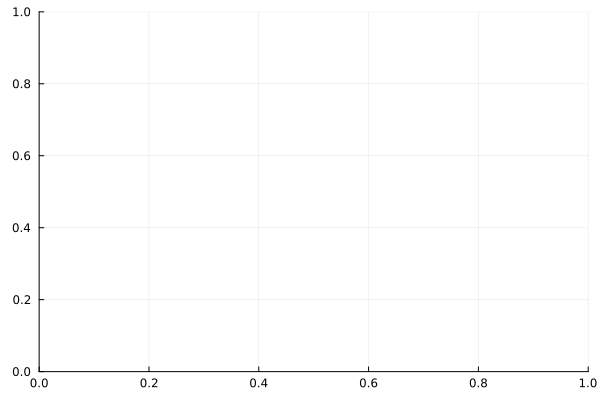

In [32]:
using DifferentialEquations, Plots, Random

# 设置随机种子
Random.seed!(1234)

# 参数设置
datasize = 50
tstep = 1
n_exp = 30  # 总实验次数，包括训练和测试
noise = 0.05
ns = 6  # 状态变量数量
atol = 1e-6
rtol = 1e-3
lb = 1e-6
ub = 1e1

# 反应速率常数的参数
logA = Float32[18.60, 19.13, 7.93]
Ea = Float32[14.54, 14.42, 6.47] * 4184  # 转换为J/mol

# Arrhenius函数定义
function arrhenius(logA, Ea, T)
    R = 8.314  # J/(mol*K)
    return exp.(logA) .* exp.(-Ea / (R * T))
end

# ODE函数定义
function true_ode_func(du, u, p, t)
    k = p
    # 反应速率方程
    r1 = k[1] * u[1] * u[2]
    r2 = k[2] * u[3] * u[2]
    r3 = k[3] * u[4] * u[2]
    du[1] = -r1  # TG
    du[2] = -r1 - r2 - r3  # ROH
    du[3] = r1 - r2  # DG
    du[4] = r2 - r3  # MG
    du[5] = r3  # GL
    du[6] = r1 + r2 + r3  # R'CO2R
end

# 初始条件
u0_list = rand(Float32, (n_exp, ns + 1))
u0_list[:, 1:2] .= u0_list[:, 1:2] .* 2.0 .+ 0.2
u0_list[:, 3:ns] .= 0.0
u0_list[:, ns + 1] .= rand(Float32, n_exp) .* 20.0 .+ 323.0  # T[K]

# 时间范围
tspan = (0.0f0, datasize * tstep)

# 生成数据集
ode_data_list = Array{Array{Float32, 2}, 1}(undef, n_exp)
time_steps_list = Array{Vector{Float32}, 1}(undef, n_exp)  # 保存每个实验的时间步
for i in 1:n_exp
    T = u0_list[i, end]
    k = arrhenius(logA, Ea, T)
    prob = ODEProblem(true_ode_func, u0_list[i, :], tspan, k)
    sol = solve(prob, Tsit5(), saveat=range(tspan[1], tspan[2], length=datasize), reltol=rtol, abstol=atol)
    ode_data = sol[1:end-1, :]  # 去掉温度项
    ode_data += randn(size(ode_data)) .* ode_data .* noise
    ode_data_list[i] = ode_data
    time_steps_list[i] = sol.t  # 保存时间步

    # Debug 输出
    println("Experiment $i:")
    println("Initial Conditions: ", u0_list[i, :])
    println("Rate Constants: ", k)
    println("ODE Solution: ", ode_data[:, 1:5])  # 只显示前5个时间点的数据
end

# 可视化生成的数据
# 使用子图来避免标签过多导致的混乱
n_subplots = min(n_exp, 5)  # 每个子图中最多显示5个实验
n_cols = 1  # 每行显示一个子图
n_rows = ceil(Int, n_exp / n_cols)  # 计算需要的行数

p = plot()
for i in 1:n_exp
    p_subplot = plot()
    for j in 1:ns
        plot!(p_subplot, time_steps_list[i], ode_data_list[i][j, :], label="Species $(j)")
    end
    plot!(p_subplot, title="Experiment $i", xlabel="Time", ylabel="Concentration", legend=:topright)
    plot!(p, p_subplot)
end

display(p)


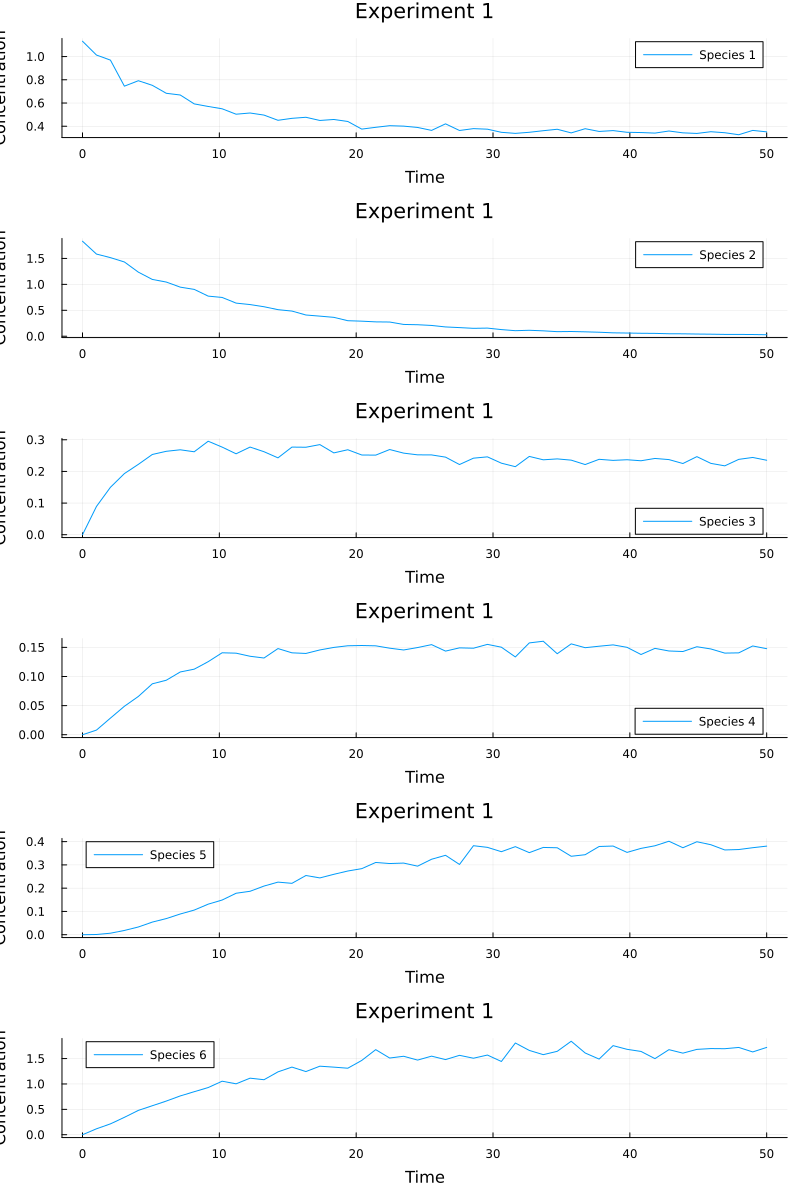

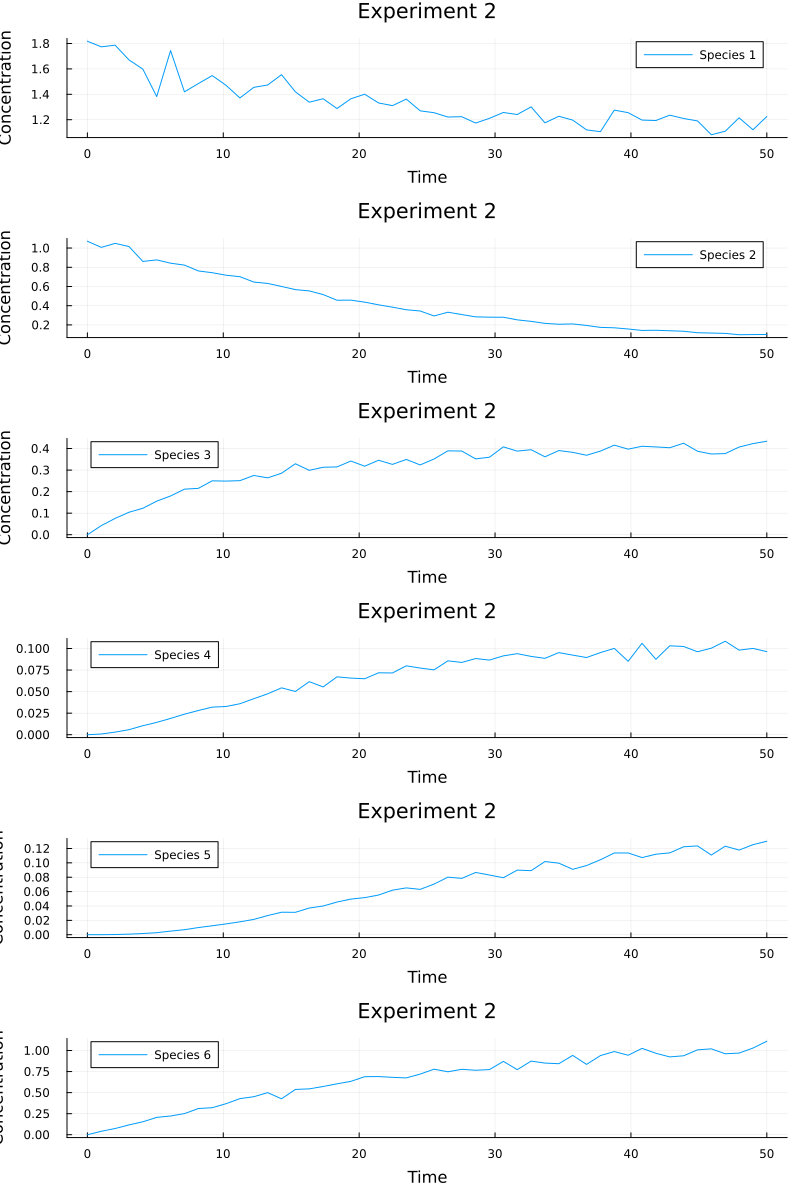

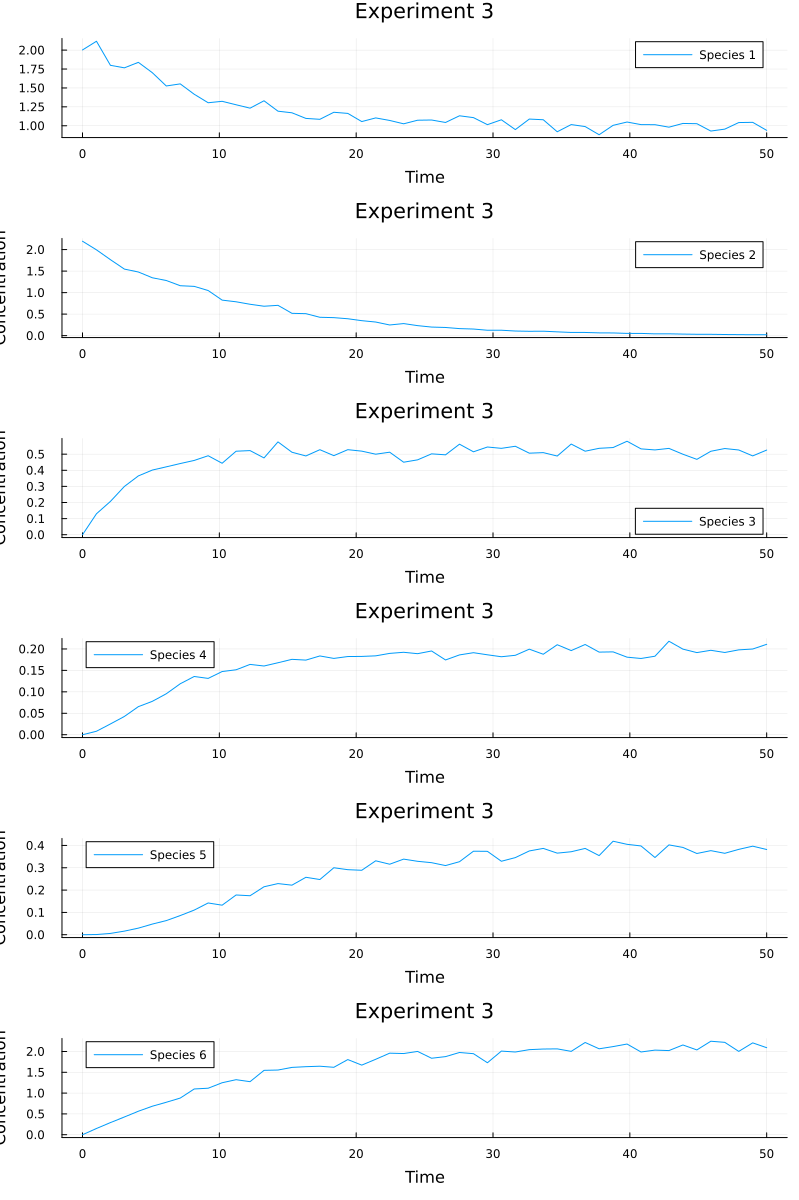

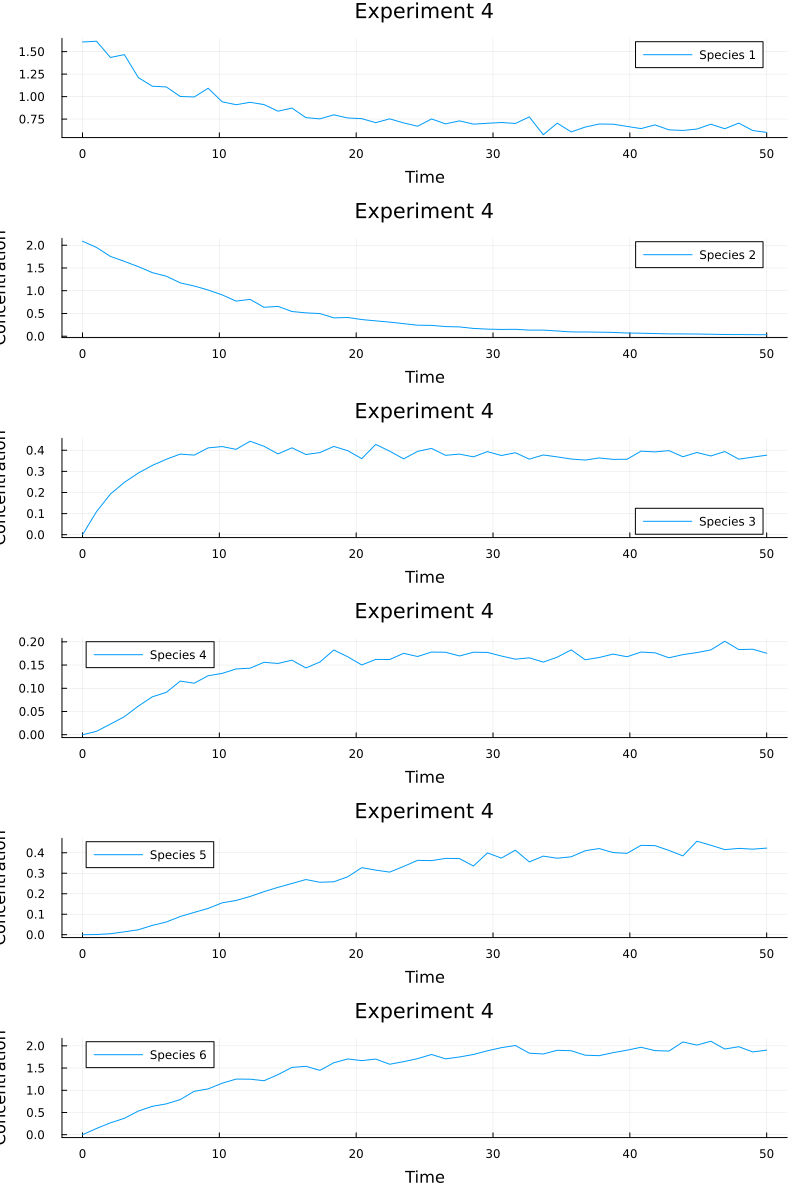

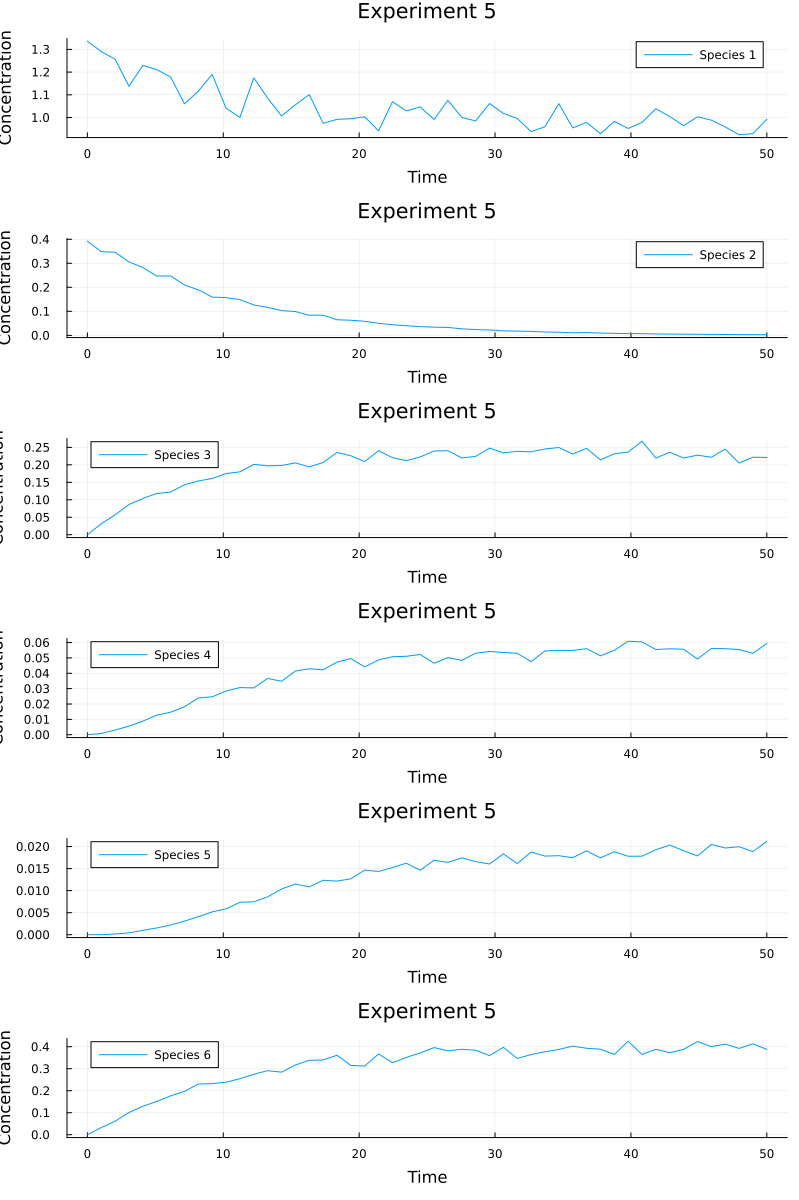

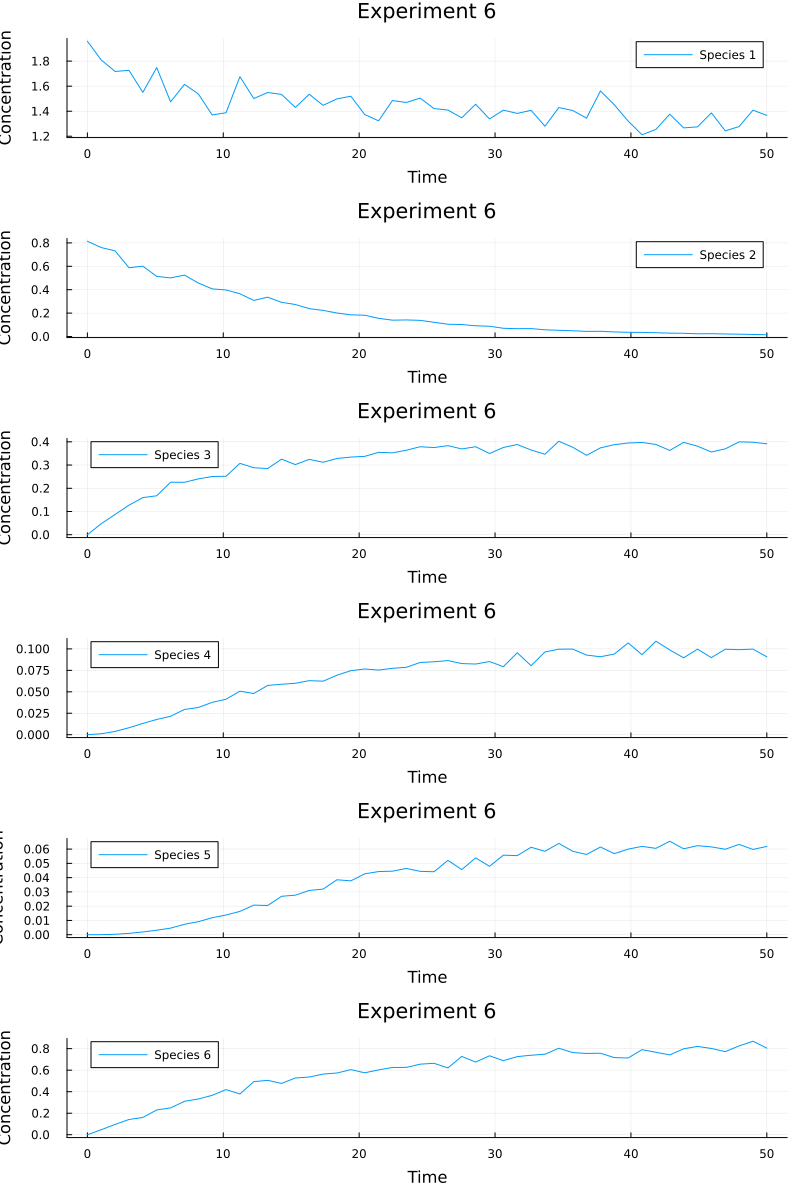

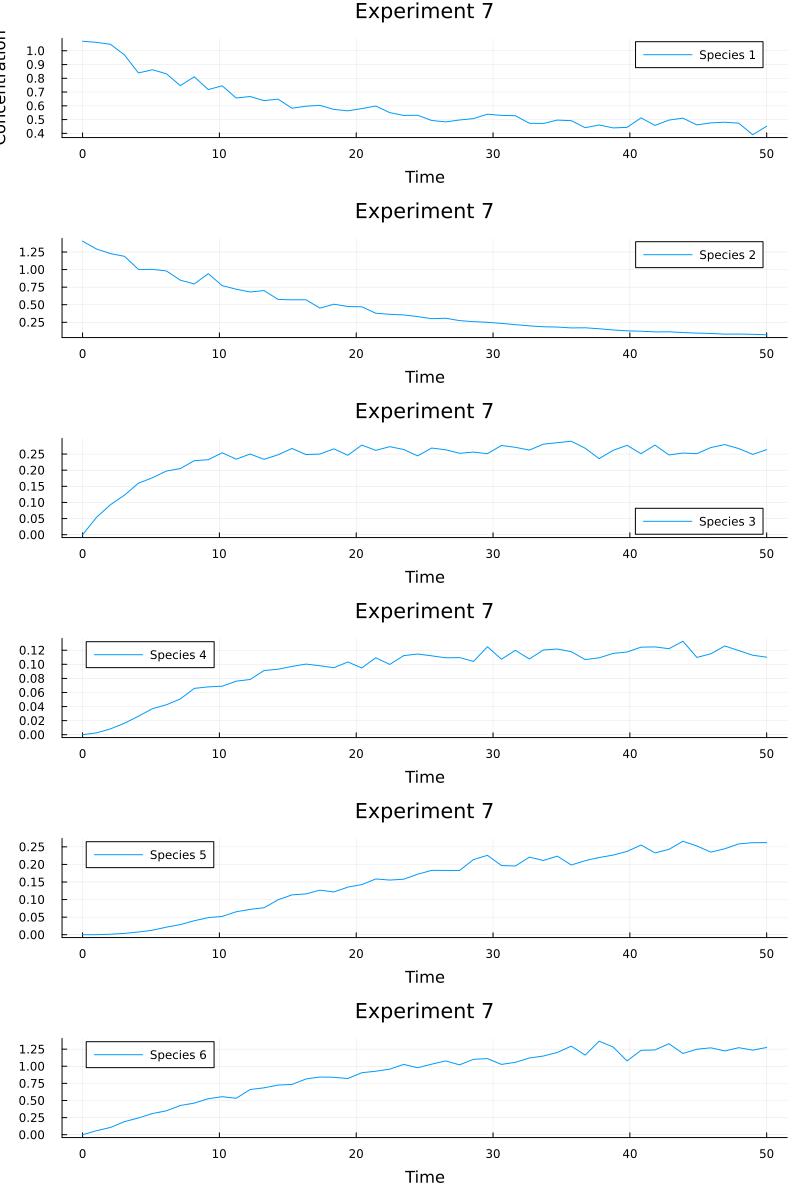

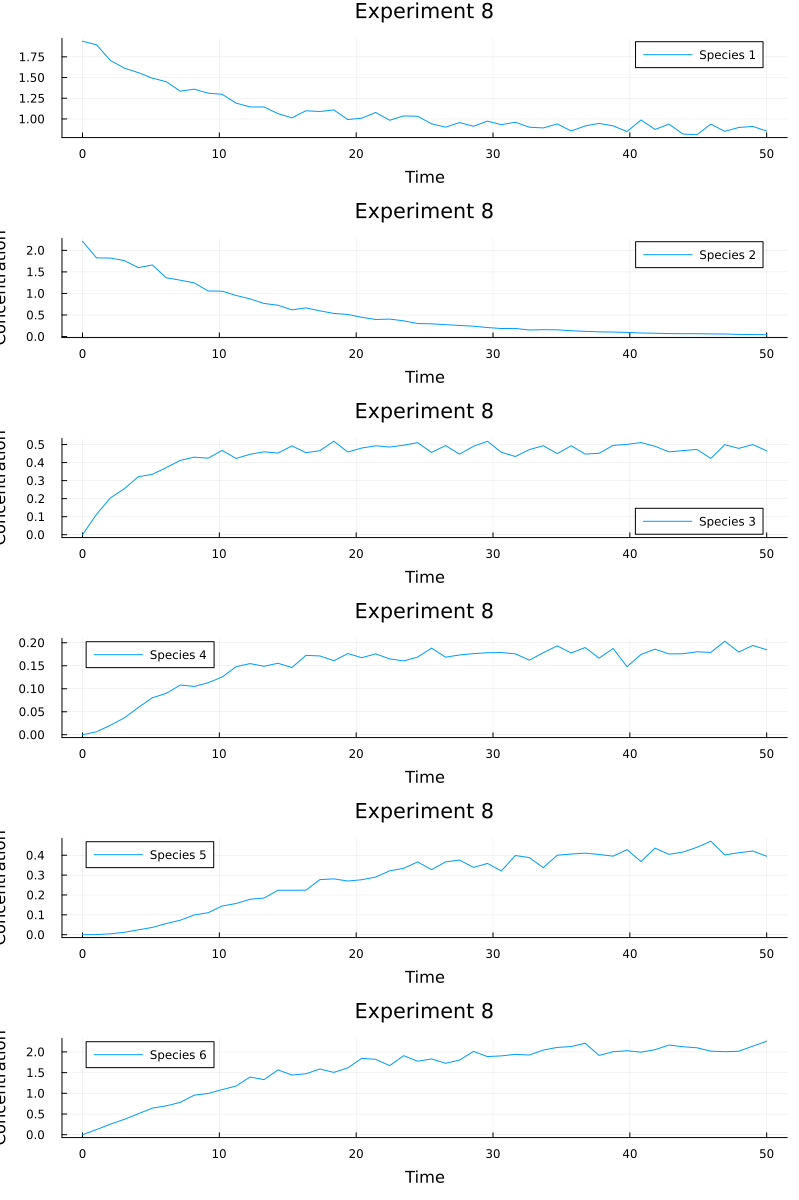

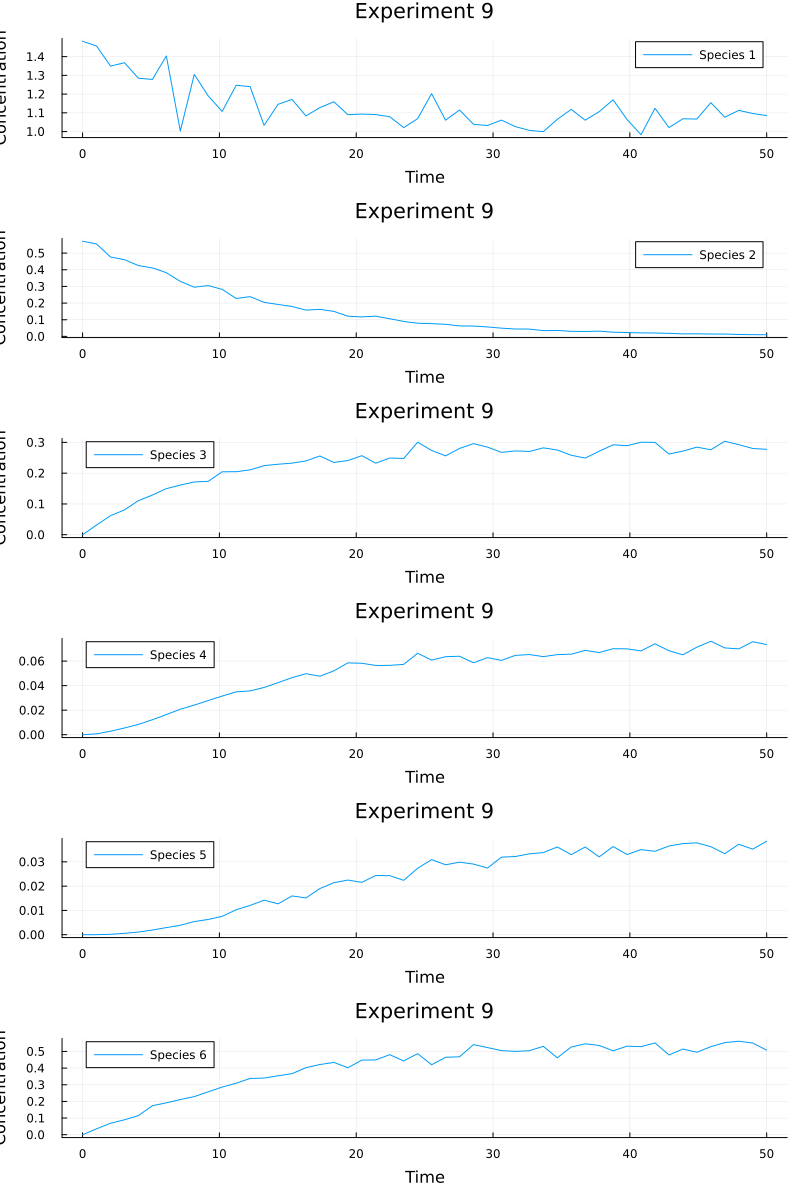

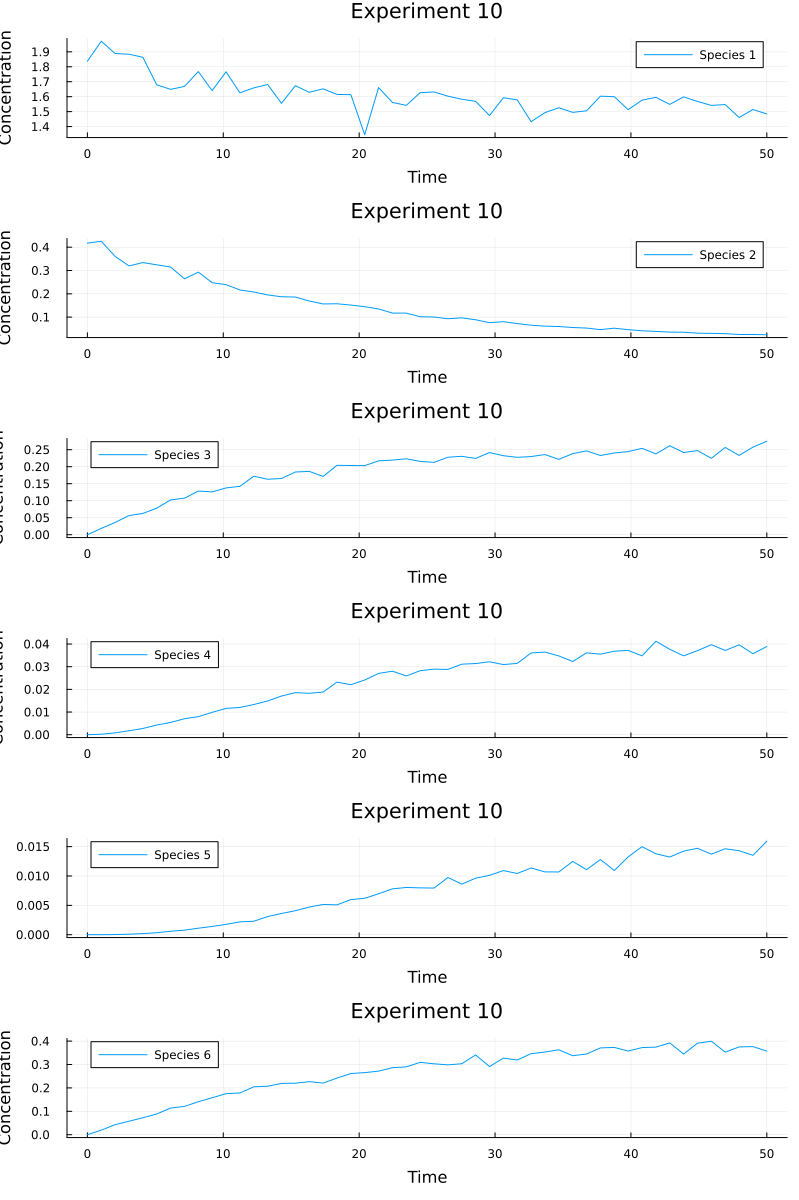

In [33]:
using OrdinaryDiffEq, Plots

# 设定实验条件
n_exp = 10 # 生成10组实验数据
datasize = 50
tstep = 1
noise = 0.05
ns = 6
alg = AutoTsit5(Rosenbrock23(autodiff=false))
tspan = Float32[0.0, datasize * tstep]
tsteps = range(tspan[1], tspan[2], length=datasize)

# 反应参数
logA = Float32[18.60f0, 19.13f0, 7.93f0]
Ea = Float32[14.54f0, 14.42f0, 6.47f0]  # kcal/mol

# Arrhenius方程
function Arrhenius(logA, Ea, T)
    R = 1.98720425864083f-3
    k = exp.(logA) .* exp.(-Ea ./ R ./ T)
    return k
end

# 真正的ODE函数
function trueODEfunc(dydt, y, k, t)
    r1 = k[1] * y[1] * y[2]
    r2 = k[2] * y[3] * y[2]
    r3 = k[3] * y[4] * y[2]
    dydt[1] = -r1  # TG
    dydt[2] = -r1 - r2 - r3  # ROH
    dydt[3] = r1 - r2  # DG
    dydt[4] = r2 - r3  # MG
    dydt[5] = r3  # GL
    dydt[6] = r1 + r2 + r3  # R'CO2R
end

# 生成初始条件
u0_list = rand(Float32, (n_exp, ns + 1))
u0_list[:, 1:2] = u0_list[:, 1:2] .* 2.0 .+ 0.2
u0_list[:, 3:ns] .= 0.0
u0_list[:, ns + 1] = u0_list[:, ns + 1] .* 20.0 .+ 323.0  # 温度[K]

# 存储生成的数据
ode_data_list = zeros(Float32, (n_exp, ns, datasize))

# 生成数据并添加噪声
for i in 1:n_exp
    u0 = u0_list[i, :]
    k = Arrhenius(logA, Ea, u0[end])
    prob_trueode = ODEProblem(trueODEfunc, u0, tspan, k)
    ode_data = Array(solve(prob_trueode, alg, saveat=tsteps))[1:end-1, :]
    ode_data += randn(size(ode_data)) .* ode_data .* noise
    ode_data_list[i, :, :] = ode_data
end

# 可视化生成的数据
for i in 1:n_exp
    plot_list = []
    for j in 1:ns
        plt = plot(tsteps, ode_data_list[i, j, :], label="Species $j", xlabel="Time", ylabel="Concentration")
        push!(plot_list, plt)
    end
    display(plot(plot_list..., layout=(ns, 1), size=(800, 1200), title="Experiment $i"))
end
